## CARMA Fit

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 09-04-20
<br>**Short description:** Explore fitting light curves using other CARMA models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
%matplotlib inline

# use mpl style on github
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
            '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)

sys.path.insert(0, '../src/')
from fit import *

### 1. Import Data & Format for fitting
#### 1.1 Import meta & LC

In [3]:
train_meta = pd.read_csv('../data/plasticc_train_metadata.csv')
train_lc = pd.read_csv('../data/plasticc_train_lightcurves.csv')

#### 1.2 Format

In [4]:
gps = train_lc.groupby(by=['object_id'])

for i, key in enumerate(gps.groups.keys()):
    if i < 5:
        print(key)
    else: break

615
713
730
745
1124


In [5]:
lc_615 = gps.get_group(615)
lc_615.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


### 2. Define Fitting function

In [6]:
from agntk.carma.CARMATerm import *
from agntk.viz.mpl_viz import *
from scipy.optimize import minimize
from scipy.optimize import rosen, differential_evolution, minimize
from celerite import GP
import celerite
import dask

In [7]:
# define log posterior function
def neg_ll(params, y, yerr, gp):
    """This method will catch 'overflow/underflow' runtimeWarning and 
    return -inf as probablility
    """
    # change few runtimewarning action setting
    notify_method = 'raise'
    np.seterr(over=notify_method)
    np.seterr(under=notify_method)
    
    params = np.array(params)
    dim = len(params)
    run = True
    lap = 0

    while run:
        if lap > 10:
            return -np.inf

        lap += 1
        try:
            gp.set_parameter_vector(params)
            neg_ll = -gp.log_likelihood(y)
            run=False
        except celerite.solver.LinAlgError:
            params += 1e-6*np.random.randn(dim)
            continue
        except np.linalg.LinAlgError:
            params += 1e-6*np.random.randn(dim)
            continue
        except FloatingPointError:
            return -np.inf
    
    return neg_ll

def carma_param_init(dim):

    log_param = np.random.uniform(-8, 1, dim)

    return log_param

In [24]:
def carma_fit(lc_df, p, q, de=True, debug=False, plot=False, bounds=None):

    best_fit = np.zeros((int(p+q+1), 6))

    # fail_num = 0
    lc_df = lc_df.copy()
    # std = np.std(lc_df.flux.values)

    if bounds is not None:
        first_bounds = bounds
    else:
        first_bounds = [(-10, 1)]*int(p+q+1)

    # loop through lc in each passband
    for band in range(6):

        try:
            lc_band = lc_df[lc_df.passband == band].copy()
            t = lc_band.mjd.values - lc_band.mjd.min()
            y = lc_band.flux.values
            yerr = lc_band.flux_err.values

            rerun = True  # dynamic control of bounds
            compute = True
            compute_ct = 0
            counter = 0
            bounds = first_bounds
            jac_log_rec = 10

            # initialize parameter, kernel and GP
            log_params = carma_param_init(int(p+q+1))
            kernel = CARMA_term(log_params[:p], log_params[p:])
            gp = GP(kernel, mean=np.mean(y))
            
            # compute can't factorize, try 4 more times
            while compute & (compute_ct < 5):
                compute_ct += 1
                try:
                    gp.compute(t, yerr)
                    compute = False
                except celerite.solver.LinAlgError:
                    gp.set_parameter_vector(carma_param_init(int(p+q+1)))

            if de:
                # set bound based on LC std for amp
                while rerun and (counter < 5):
                    counter += 1
                    r = differential_evolution(
                        neg_ll, bounds=bounds, args=(y, yerr, gp), maxiter=200
                    )

                    if r.success:
                        best_fit[:, band] = np.exp(r.x)

                        if "jac" not in r.keys():
                            rerun = False
                        else:
                            jac_log = np.log10(np.dot(r.jac, r.jac) + 1e-8)

                            # if positive jac, then increase bounds
                            if jac_log > 0:
                                bounds = [(x[0] - 1, x[1] + 1) for x in bounds]
                            else:
                                rerun = False

                            # update best-fit if smaller jac found
                            if jac_log < jac_log_rec:
                                jac_log_rec = jac_log
                                best_fit[:, band] = np.exp(r.x)
                    else:
                        bounds = [(x[0] - 1, x[1] + 1) for x in bounds]
                        gp.set_parameter_vector(carma_param_init(int(p+q+1)))

            else:
                initial_params = gp.get_parameter_vector()

                while rerun and (counter < 5):
                    counter += 1
                    r = minimize(
                        neg_ll,
                        initial_params,
                        method="L-BFGS-B",
#                         bounds=bounds,
                        args=(y, yerr, gp),
                    )
                    if r.success:
                        best_fit[:, band] = np.exp(r.x)
                        jac_log = np.log10(np.dot(r.jac, r.jac) + 1e-8)

                        # if positive jac, then increase bounds
                        if jac_log > 0:
                            bounds = [(x[0] - 1, x[1] + 1) for x in bounds]
                        else:
                            rerun = False

                        # update best-fit if smaller jac found
                        if jac_log < jac_log_rec:
                            jac_log_rec = jac_log
                            best_fit[:, band] = np.exp(r.x)
                    else:
                        bounds = [(x[0] - 1, x[1] + 1) for x in bounds]
                        gp.set_parameter_vector(carma_param_init(int(p+q+1)))

            if not r.success:
                best_fit[:, band] = np.nan



        except Exception as e:
            print(e)
            print(
                f"Exception at object_id: {lc_df.object_id.values[0]}, passband: {band}"
            )
            best_fit[:, band] = np.nan

        # Below code is used to visualize if stuck in local minima
        if debug:
            print(r)

#         if plot:
#             plot_dho_ll(t, y, yerr, np.exp(r.x), gp, vec_neg_ll)

    return np.concatenate([[lc_df.object_id.values[0]], best_fit.flatten()])

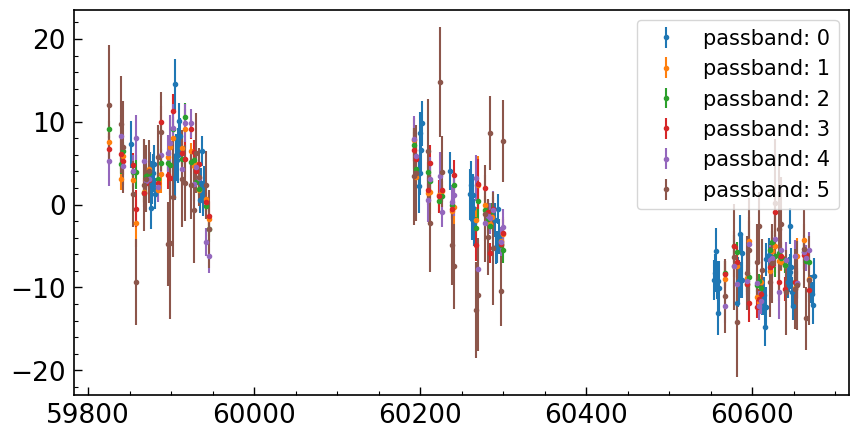

In [25]:
lc = gps.get_group(713)
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
plt.legend(fontsize=15)

In [26]:
p = 2
q = 0
best_fit = carma_fit(lc, p, q, de=True, debug=False)[1:].reshape((p+q+1,6))
np.log(best_fit)

array([[ 1.        ,  0.2931445 , -1.42902791,  1.        , -1.80042562,
         0.20326599],
       [-4.4944837 , -4.9591133 , -6.3950392 , -3.69380882, -6.19086411,
        -6.10393531],
       [ 0.5318857 , -0.21522856, -1.77003789,  0.80298001, -1.82891014,
        -0.99113451]])

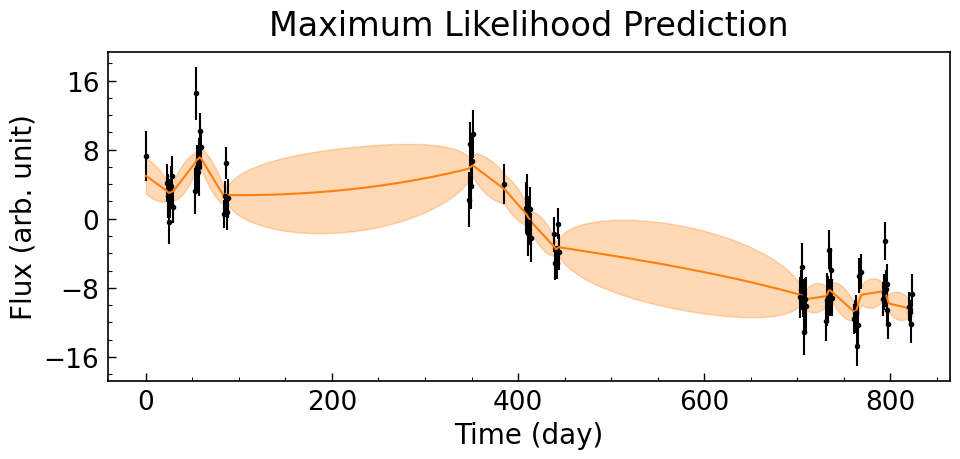

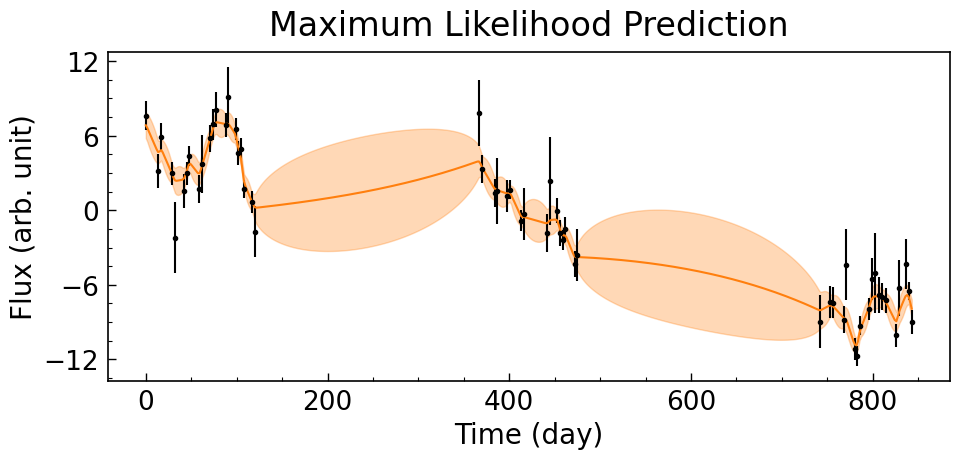

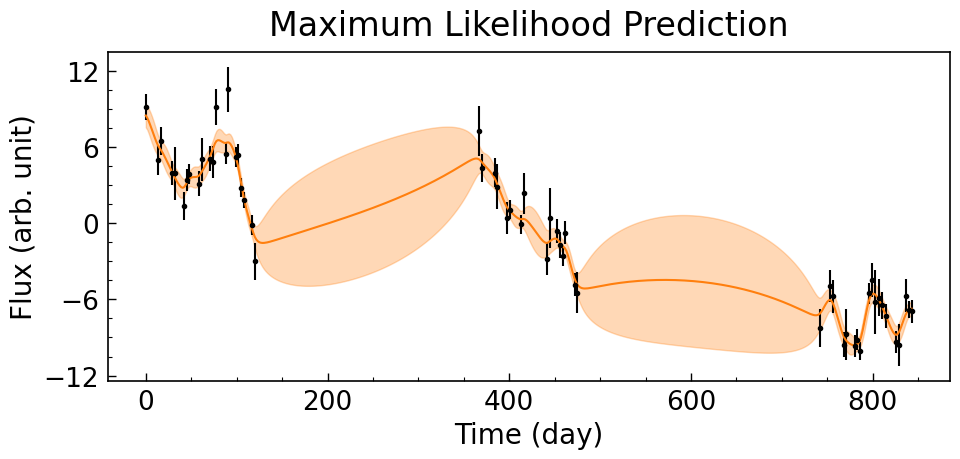

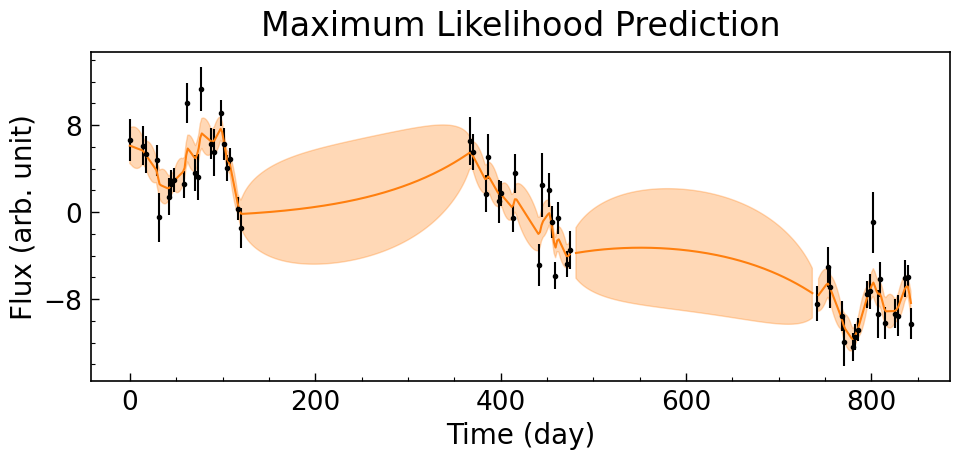

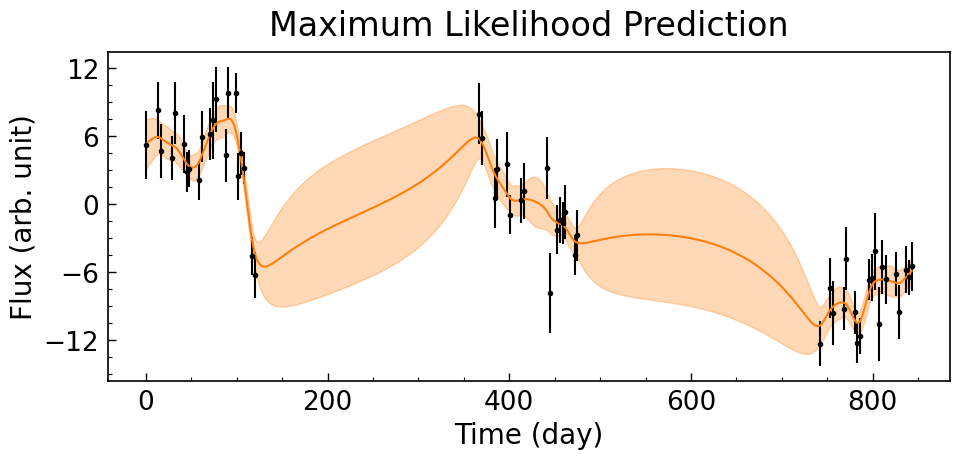

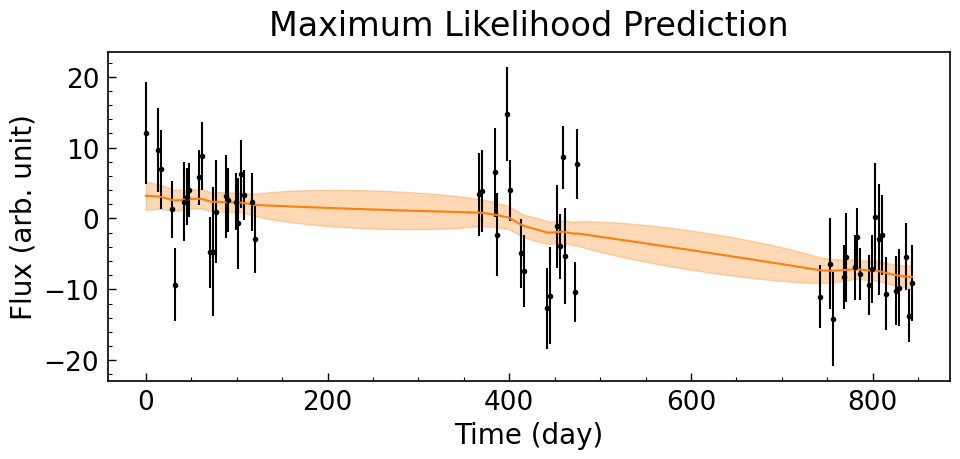

In [27]:
for band in range(0,6):
    lc_g = lc[lc.passband == band]
    plot_pred_lc(lc_g, best_fit[:, band], p, q, time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')

<span style='color:red'>__NOTE/IMPORTANT:__</span> Althought the code above will fit CARMA models above DHO/CARMA(2,1), it is hard to achieve a stable/best solution. This could be caused the optimizer being not robust enough or the boundary specified not correct. However, even using $\texttt{scipy.optimize}$ without no bounds provided will not give reliable solutions.

### 3. Look at a few examples of non-AGN variables

#### 3.1 Object: 86456, Targe: 42, Type: Core Collapse Type II SN

In [28]:
train_meta[train_meta.object_id == 86456]

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
506,86456,33.5742,-5.3794,1,0.213,0.219,0.014,40.178,0.017,42,42,3,0.213,40.112,0.001,-65.9,3.1,0.329,59762.879,6,0.0,0.0,0.0,0.0,0.0,0.0


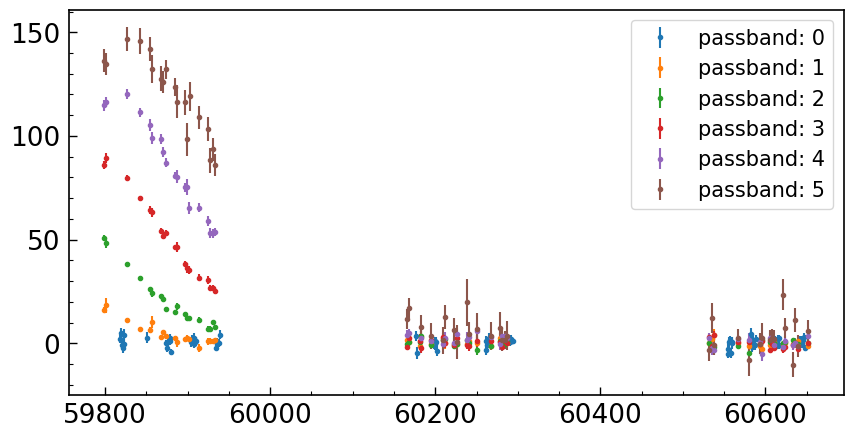

In [29]:
lc = train_lc[train_lc.object_id == 86456].copy()
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
#     scale_y =np.log(lc_per_f.flux+meta[f'tflux_{bands[band]}'].values[0])
#     plt.scatter(lc_per_f.mjd, scale_y - np.mean(scale_y), s=2,
#         label=f'passband: {band}')
plt.legend(fontsize=15)

In [30]:
best_fit = carma_fit(lc, 2, 0)[1:].reshape((3,6))
np.log(best_fit)

array([[-10.        ,  -4.56302834,  -5.65629154,  -5.73933069,
         -4.80868479,  -5.25393512],
       [ -2.13672918,  -8.82084081, -10.        , -10.        ,
         -9.65269207, -10.        ],
       [ -6.48951032,  -4.53070615,  -4.12424916,  -3.89686167,
         -3.19925729,  -3.41170567]])

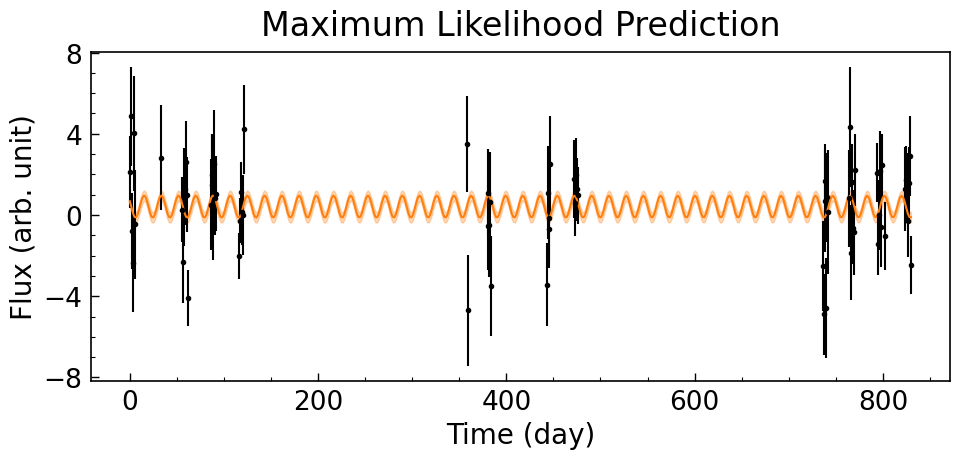

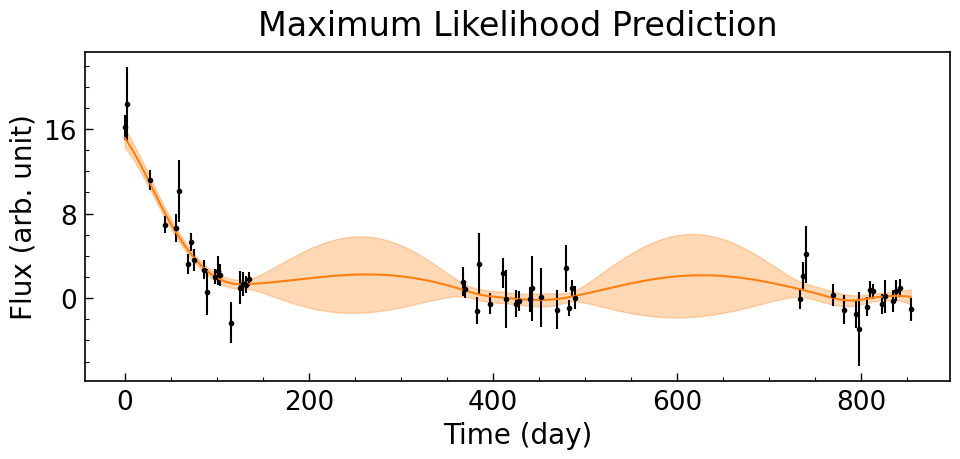

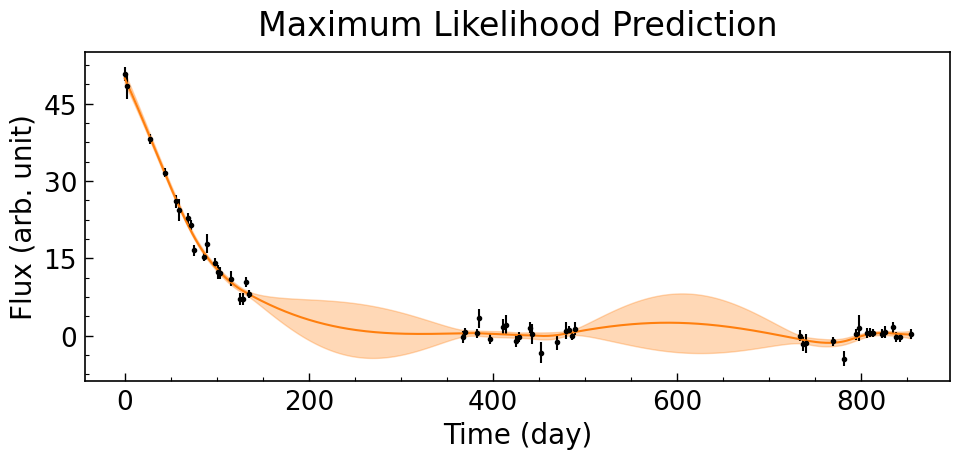

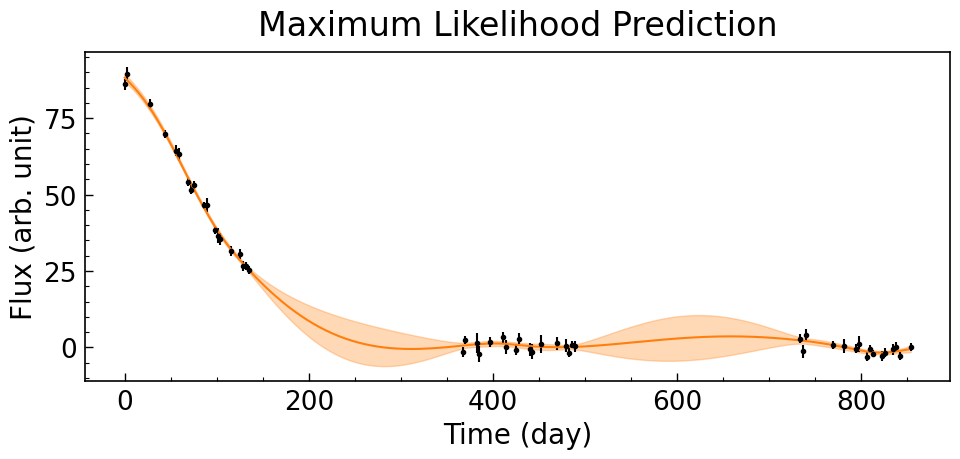

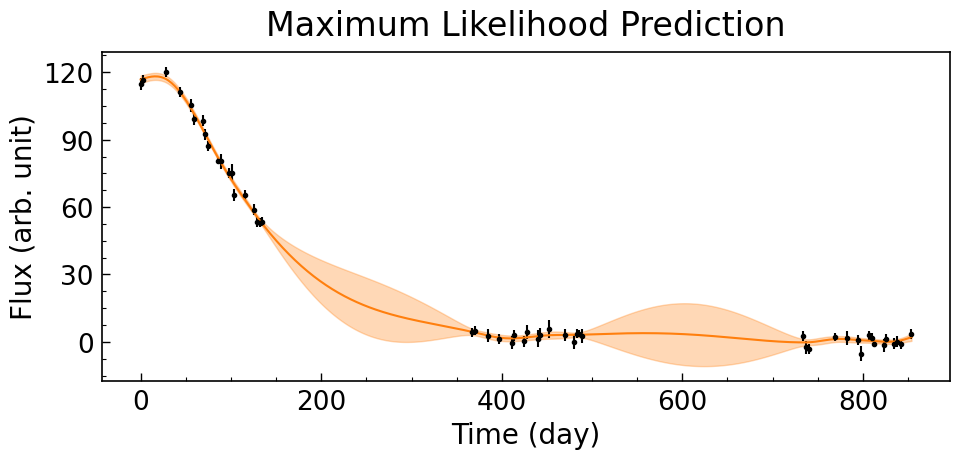

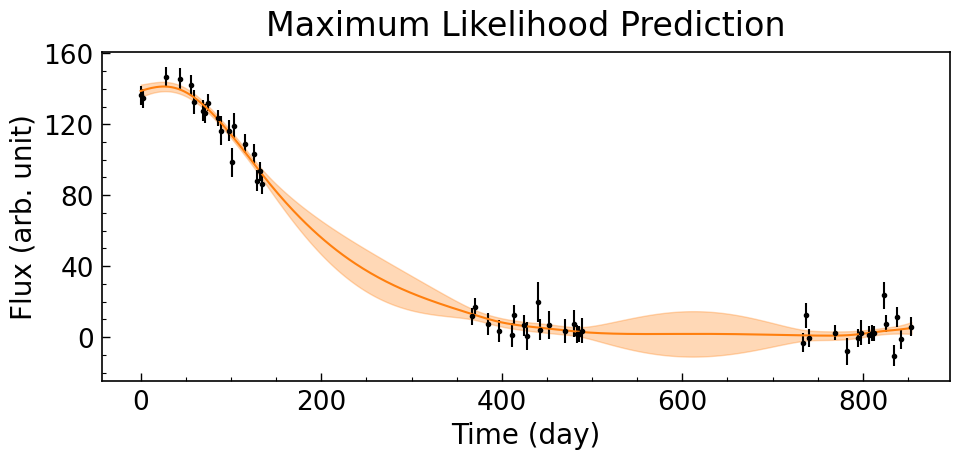

In [31]:
for band in range(0,6):
    lc_g = lc[lc.passband == band]
    plot_pred_lc(lc_g, best_fit[:, band], 2, 0, time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')

#### 3.2 Object: 12695, Target: 92, Type: RRL

In [32]:
train_meta[train_meta.object_id == 12695]

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
69,12695,51.8555,-28.631,1,0.0,0.0,0.0,-9.0,0.009,92,92,1,0.0,0.0,0.0,0.0,0.0,0.0,59570.0,27,1012.8,6358.9,7485.6,7421.9,7413.8,7362.2


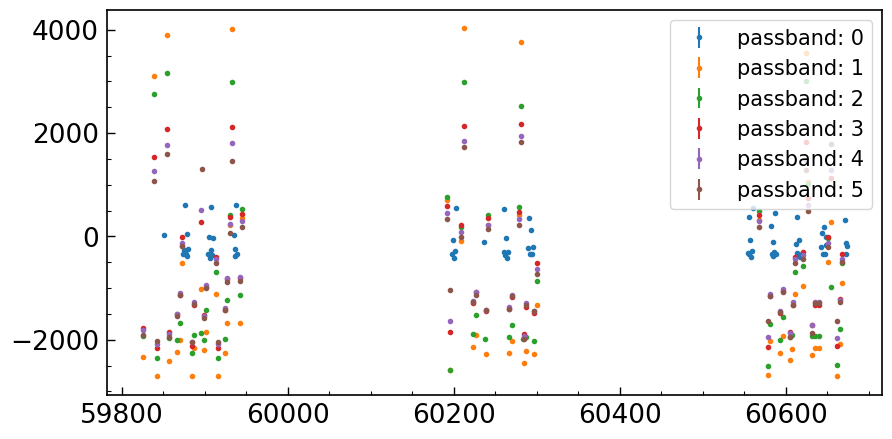

In [33]:
lc = train_lc[train_lc.object_id == 12695].copy()
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
#     scale_y =np.log(lc_per_f.flux+meta[f'tflux_{bands[band]}'].values[0])
#     plt.scatter(lc_per_f.mjd, scale_y - np.mean(scale_y), s=2,
#         label=f'passband: {band}')
plt.legend(fontsize=15)

In [35]:
best_fit = carma_fit(lc, 2, 0)[1:].reshape((3,6))
np.log(best_fit)

array([[-3.55492323, -4.02491934, -3.77443176, -3.20528777, -3.03953436,
        -2.94879481],
       [ 1.45689828, -1.84283082, -1.90697491, -1.84071949, -1.83339683,
        -1.86363519],
       [ 5.        ,  5.        ,  5.        ,  5.        ,  5.        ,
         5.        ]])

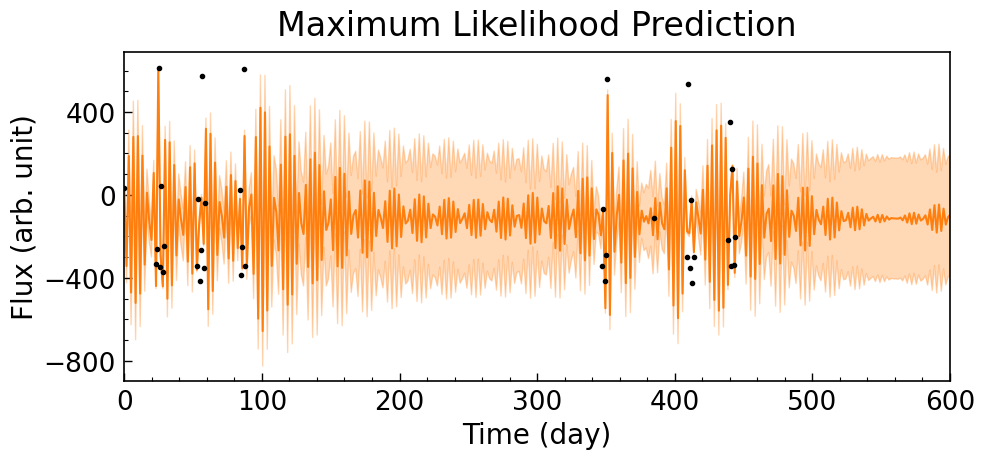

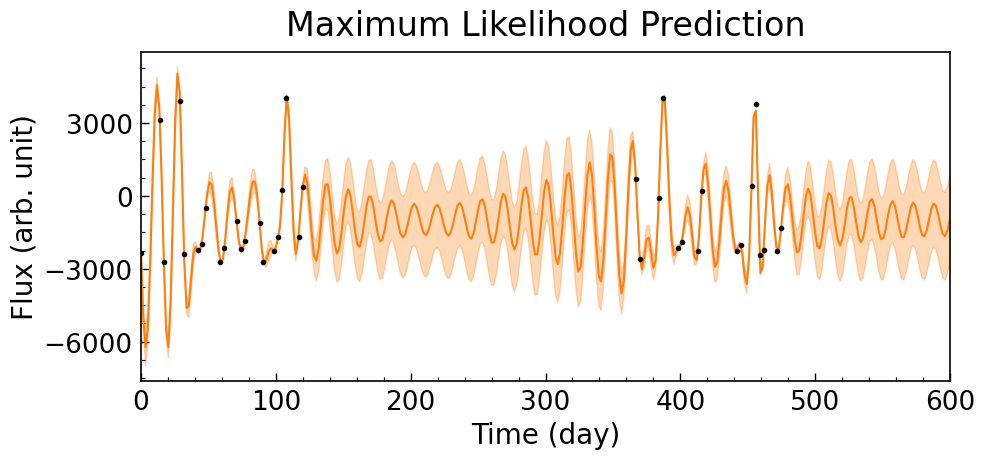

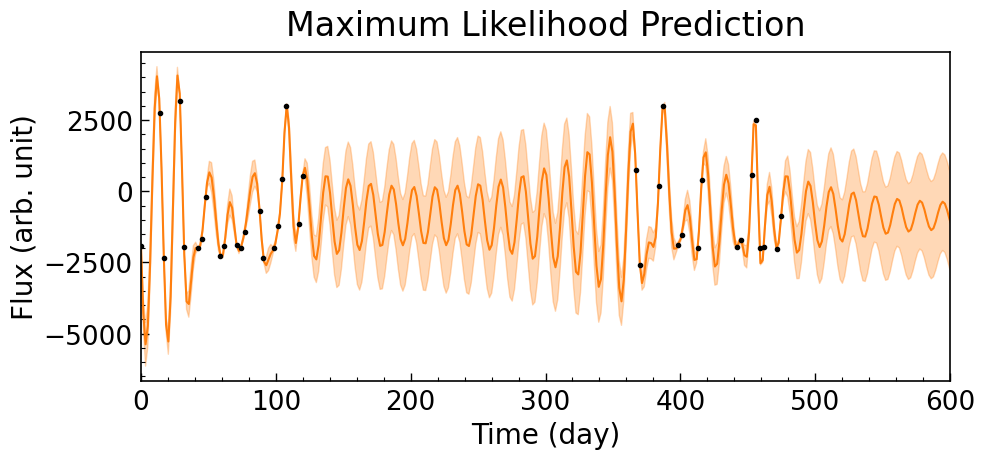

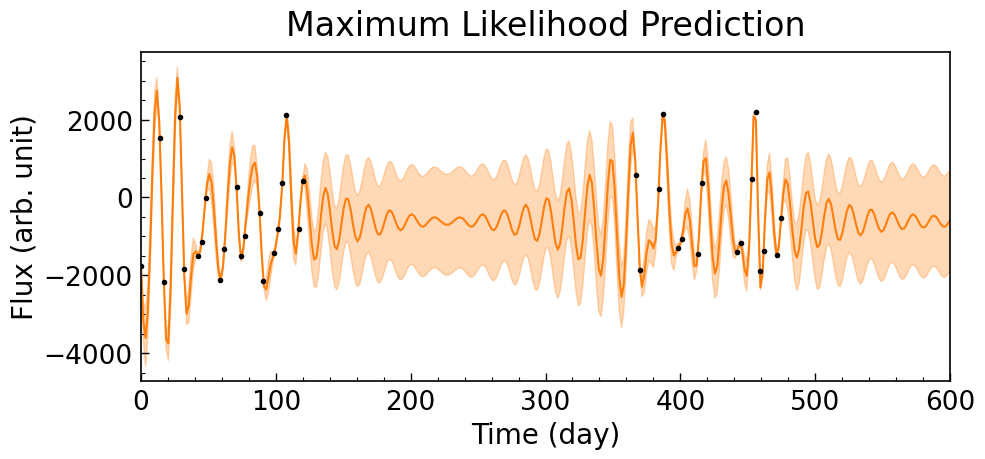

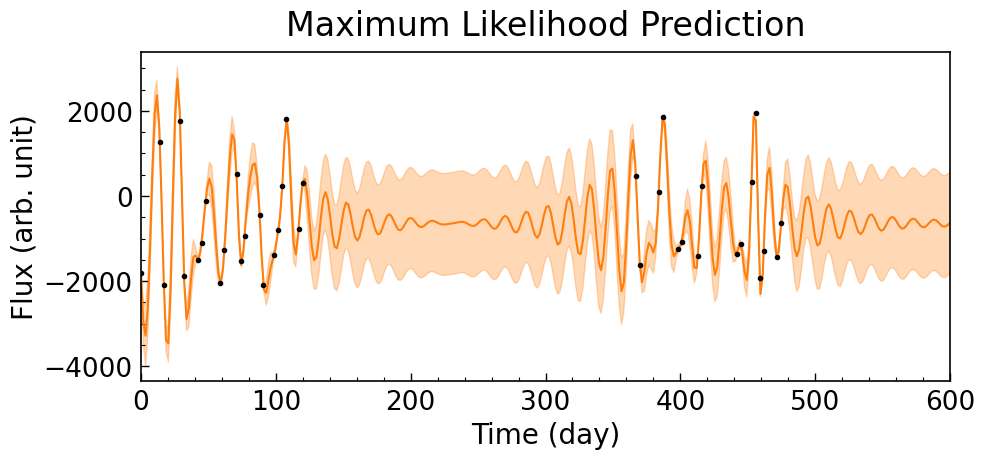

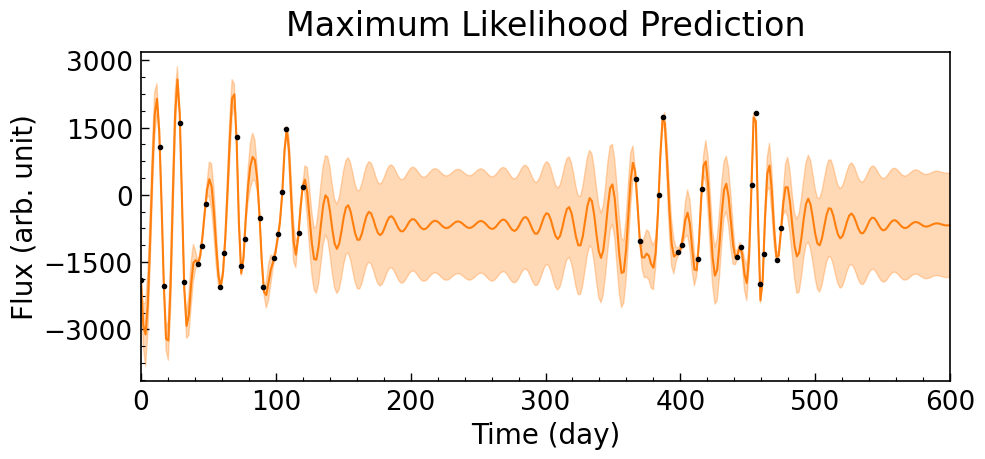

In [36]:
for band in range(0,6):
    lc_g = lc[lc.passband == band]
    plot_pred_lc(lc_g, best_fit[:, band], p, q, time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')
    plt.xlim(0,600)

#### 3.3 Object: 18645, Target: 62, Type: Core Collapse, Type Ibc SN

In [37]:
train_meta[train_meta.object_id == 18645]

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
110,18645,358.6364,-46.7685,1,0.164,2.303,1.102,46.331,0.008,62,62,1,0.164,39.479,-0.001,278.1,0.0,0.0,60380.27,77,0.0,0.0,0.0,0.0,0.0,0.0


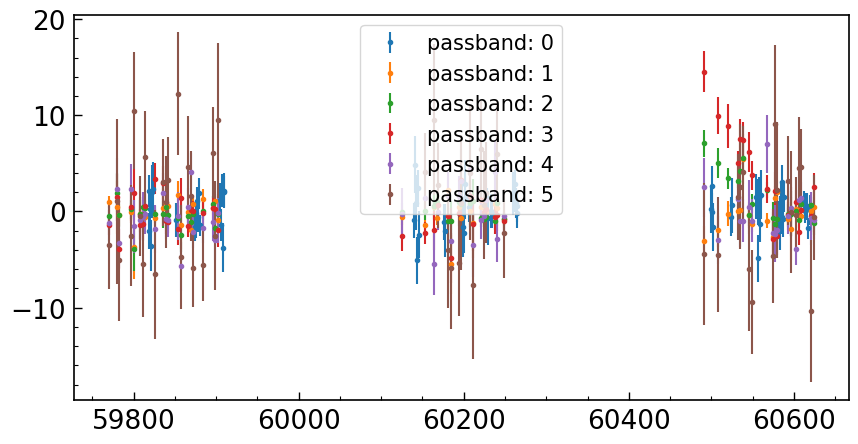

In [38]:
lc = train_lc[train_lc.object_id == 18645].copy()
max_err = np.percentile(lc.flux_err, 99)
lc = lc[lc.flux_err < max_err]
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
#     scale_y =np.log(lc_per_f.flux+meta[f'tflux_{bands[band]}'].values[0])
#     plt.scatter(lc_per_f.mjd, scale_y - np.mean(scale_y), s=2,
#         label=f'passband: {band}')
plt.legend(fontsize=15)

In [39]:
best_fit = carma_fit(lc, p, q)[1:].reshape((3,6))
np.log(best_fit)

array([[-10.        ,  -9.57302227,  -4.21718787,  -3.9555814 ,
        -10.        ,  -9.26101925],
       [ -1.38351834,  -2.32571946,  -8.13067413,  -7.90508236,
         -2.68726706,  -1.38098346],
       [ -6.56155255,  -6.48523303,  -5.32494319,  -4.15921497,
         -6.24389613,  -4.31433167]])

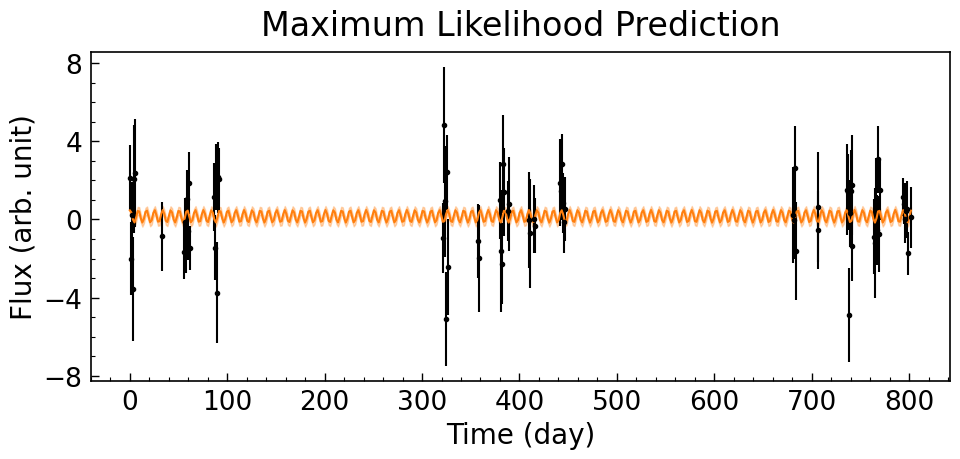

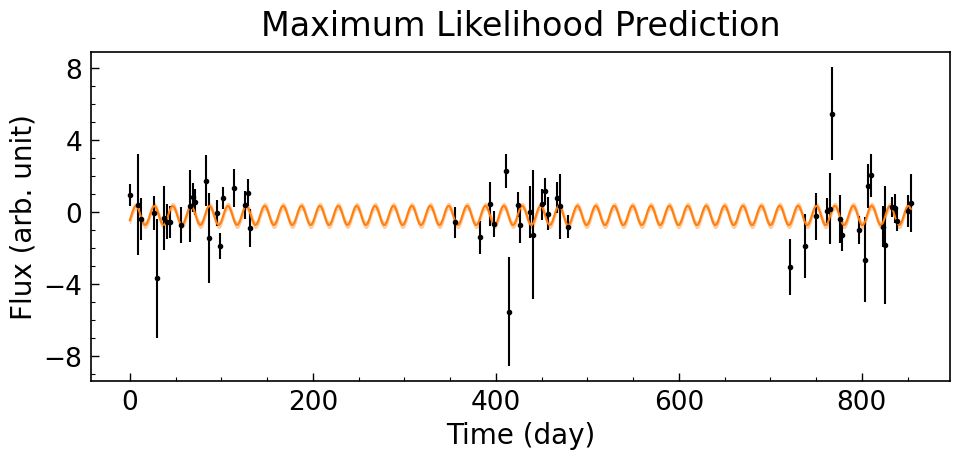

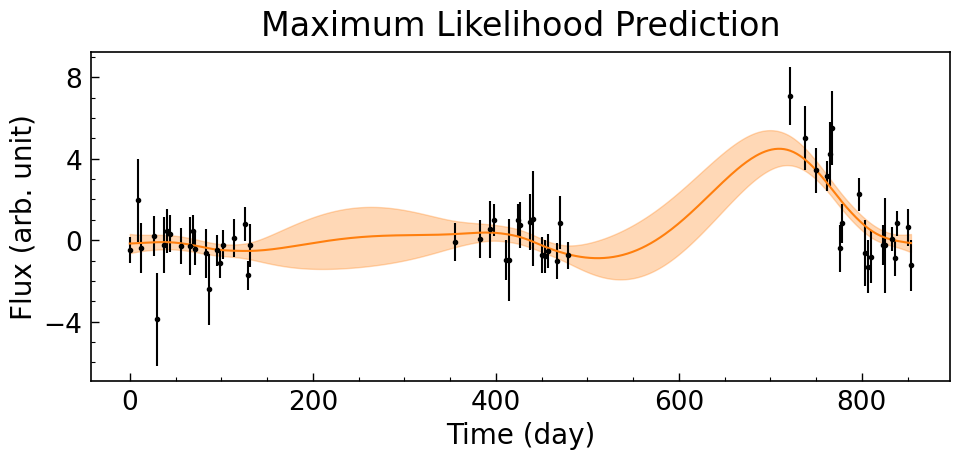

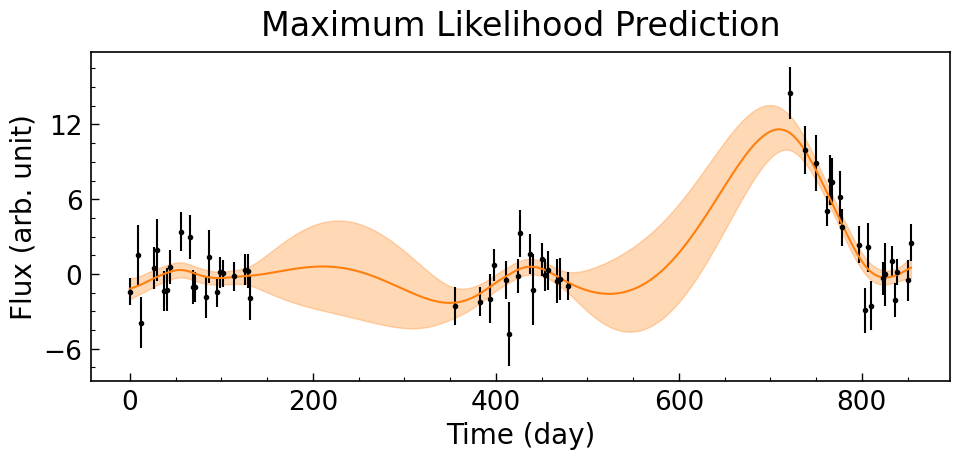

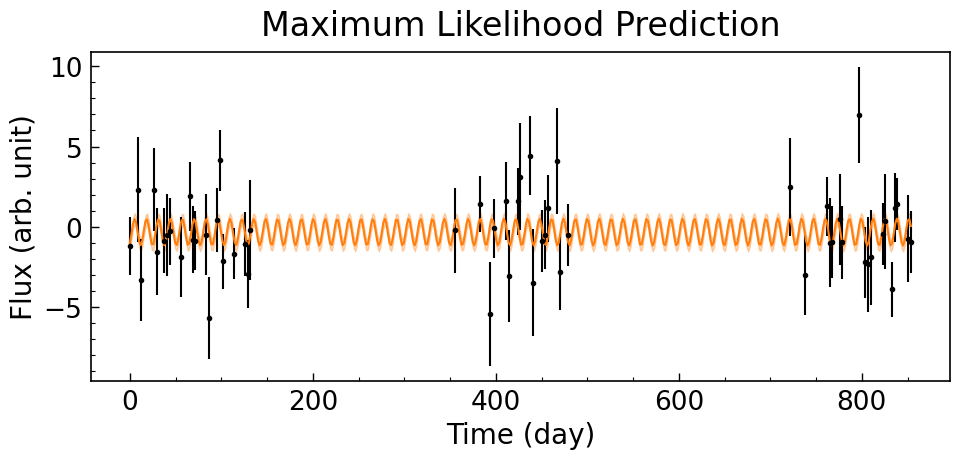

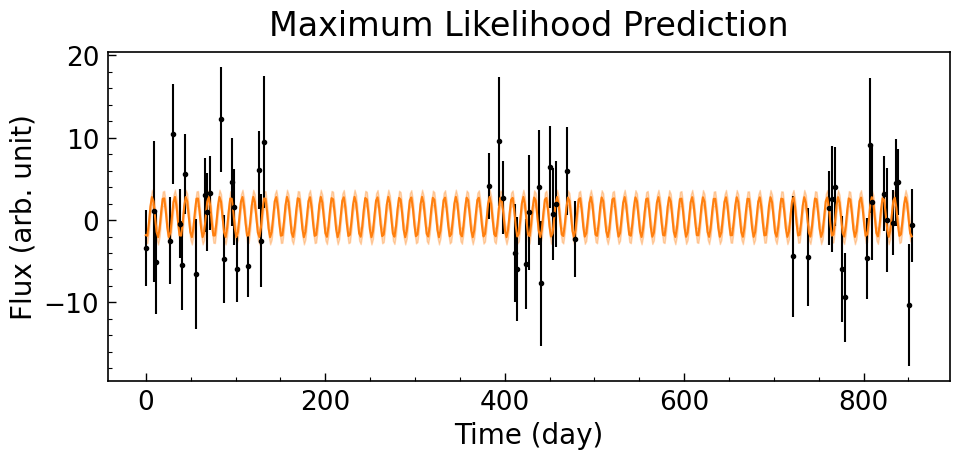

In [41]:
for band in range(0,6):
    lc_g = lc[lc.passband == band]
    plot_pred_lc(lc_g, best_fit[:, band], p, q, time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')

<span style='color:red'>__Conclusion:__</span> 
- Light curves with very low amplitude (comparable to noise level) can't achieve reliable/consistent DHO fits, but most of them find the best solution as a combination of sinusoidal waves. 
- DHO seems to provide better predicted light curves for SNe, in terms of shape and the precision. 
- Fitting simulated DRW light curves with DHO will generate inconsistent results (e.g., between bands)
- DHO doesn't fit RR Lyrae well